# Wine Quality Classification Exercise

In this notebook, you will train a small algorithm to predict the quality of wines. By doing so, you will explore the main steps of a Data Science project. 

The notebook is organised as follows:

A. Introductory tutorial:
1. Import: set up the notebook and load the dataset
2. Data exploration: analyse the content of the dataset
3. Data preparation: select and modify the data
4. Training a model: define and train the model
5. Performance evaluation: assess the performance of the model

B. Exercises:

1. Model tuning: tune a model to improve its performance
2. Feature selection: analyse the impact of cleverly selected features
3. Models comparison: compare the performance of different models
4. Results analysis: analyse the results
5. Interpretability: understand how the models makes its predictions

----------------

# A. Introductory tutorial

For the tutorial, we will use a dataset from a [study](#refs) which provides information about different wines and rates their quality from 1 to 10. To simplify the exercise, we modified the dataset, providing either a "good" or a "bad" label for each wine. Our objective is to predict if a wine is good based on its features (acidity, sugar, ...). For instance, this could be used as a tool to select the sale price.

## 1. Import

First, the libraries are imported, and the data is loaded.

### 1.1 Settings

In [1]:
# Libraries
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

### 1.2. Loading

In [2]:
# Load the df
df = pd.read_csv(os.path.join("wine_quality.csv"), index_col=0)

## 2. Data exploration

### 2.1 Data inspection

We start by looking at the content of the file.

In [3]:
print(
    "The df contains {} wines; {} of them are classified as good.".format(
        len(df), df["quality"].sum()
    )
)
df.head(10)

The df contains 1499 wines; 796 of them are classified as good.


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,1
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,1
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,0


In [4]:
print("The columns are: {}".format(df.columns.values))

The columns are: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']


An important step is to check the data's sanity. Here, there is no invalid or missing value (see below). However, in most real case scenarios, there are missing values. Removing the rows with missing values is an option if one has many datapoints. Else, there are different advanced methods to deal with it.

In [5]:
# Check NaN values
print("Number of NaN values is: {}".format(df.isnull().sum().sum()))

Number of NaN values is: 0


### 2.2 Correlation between the features and the target

*Reminder: in this context, correlation measures how one variable linearly influences another. A value of 1 means that when variable A increases, B increases too. A value of 0 means that modifying A doesn't impact B. A value of -1 means that when variable A increases, B decreases. Intermediate values show in-between relationships. [More here](https://en.wikipedia.org/wiki/Correlation)*

First, we want to determine which features correlate with our target (wine quality). Features poorly correlated to the target may bring little information to the models. Thus, we may exclude them as they will add complexity without benefit.

From the results below, in a real-world scenario, we might want to exclude "residual sugar" and "pH", which are poorly linearly correlated to our objective.

In [6]:
df.corr()["quality"].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.433951
sulphates               0.211790
citric acid             0.161402
fixed acidity           0.112565
residual sugar         -0.005257
pH                     -0.013893
free sulfur dioxide    -0.062626
chlorides              -0.107843
density                -0.154370
total sulfur dioxide   -0.232504
volatile acidity       -0.330018
Name: quality, dtype: float64

### 2.3 Correlation between the features

Second, we want to see how the features themselves correlate together. Two highly correlated features contain the same information, and providing only one to the model is thus sufficient.

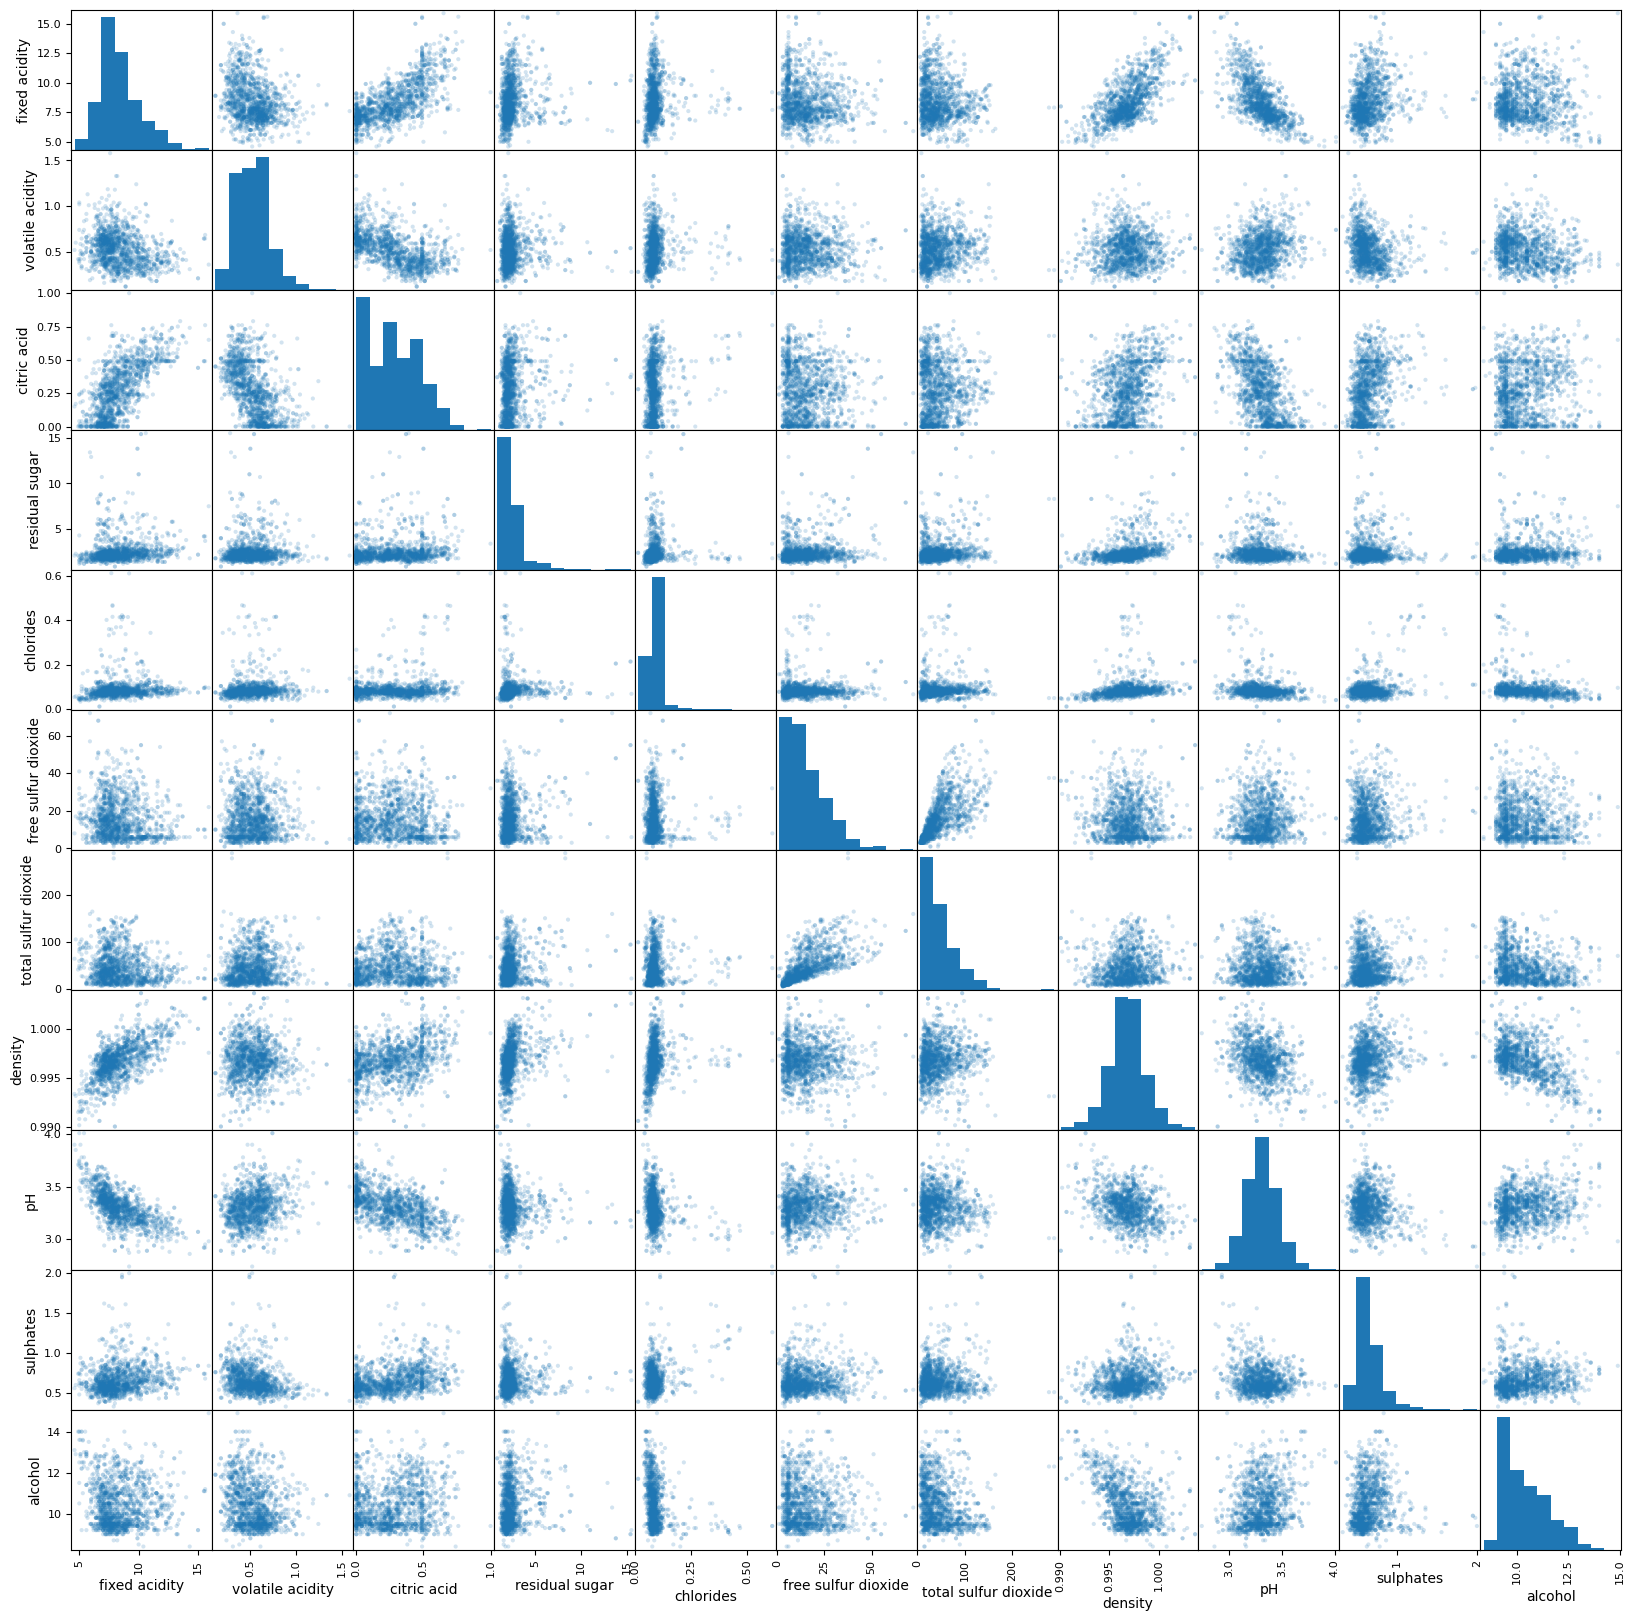

In [7]:
# Visualise the scatter plot between the features
pd.plotting.scatter_matrix(df.drop(columns=["quality"]), alpha=0.2, figsize=(20, 20))
plt.show()

The above plot shows that some features are somewhat correlated (they draw lines, like "fixed acidity" and "citric acidity"). To confirm that, we compute the intercorrelation matrix (below).

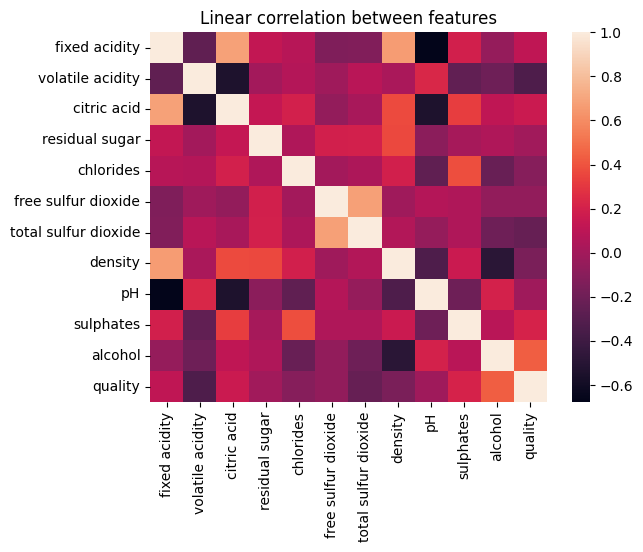

In [8]:
sns.heatmap(df.corr())
plt.title("Linear correlation between features")
plt.show()

In [9]:
# Look at higer intercorrelation values between features (more than 66%)
corr = df.corr()
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if abs(corr.iloc[i, j]) >= 0.66:
            print(df.columns[i], " and ", df.columns[j], ": ", corr.iloc[i, j])

fixed acidity  and  citric acid :  0.6841789096071444
fixed acidity  and  density :  0.665174689773179
fixed acidity  and  pH :  -0.6767083536531788
free sulfur dioxide  and  total sulfur dioxide :  0.6734463638572784


The results above show that some pairs of features contain similar information. However, the correlation is not strong enough, and removing one may result in losing information. One may argue that "fixed acidity" is correlated with three other variables and may thus be removed.

## 3. Data preparation


### 3.1 Train-Test splitting
One challenge in Machine Learning is overfitting (the algorithm learns how to solve the task with the given data but cannot generalise to new data). 

To check if the algorithm has overfitted, one has to separate the dataset between a *training* and a *testing* dataset. The first part is used to train the algorithm and fine-tune its parameters, whereas the second is used to check afterwards that the model can generalise to new data.

In [10]:
# Separate train and test clients
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Separate features and targets
y_train = df_train["quality"]
X_train = df_train.drop(columns=["quality"])
y_test = df_test["quality"]
X_test = df_test.drop(columns=["quality"])

## 4. Training the model

In [11]:
# Define the classifier
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=1000, random_state=42)

In [12]:
# Fit it with the training data
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,1000
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


We can see a drawing of the decision tree just trained.

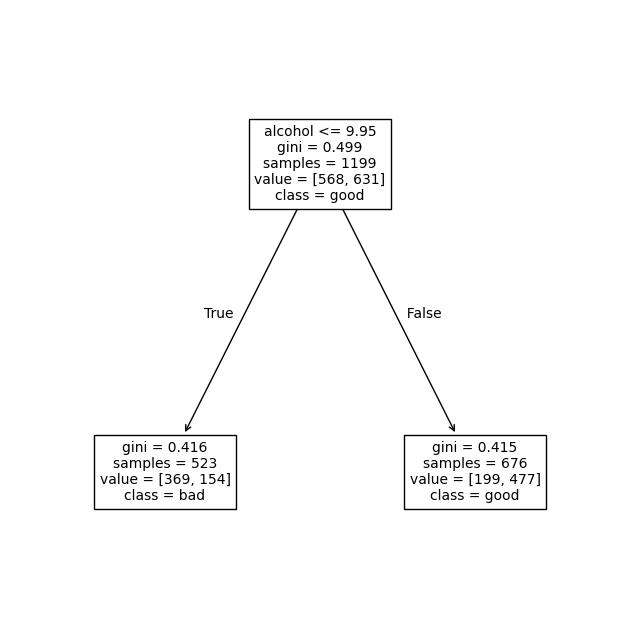

In [13]:
plt.figure(figsize=(8,8))
plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=["bad", "good"])
plt.show()

## 5. Performance evaluation

Finally, we have to check the performance reached by the trained model. 

### 5.1 On training data

First, we check the model's performance on training data.

A way to analyse the performance is the confusion matrix (below); this tool provides the amount of True Positive, False Positive, True Negative and False Negative ([More here](https://en.wikipedia.org/wiki/Confusion_matrix)). The accuracy is also computed.

On training data, the algorithm reaches 70.56% of accuracy


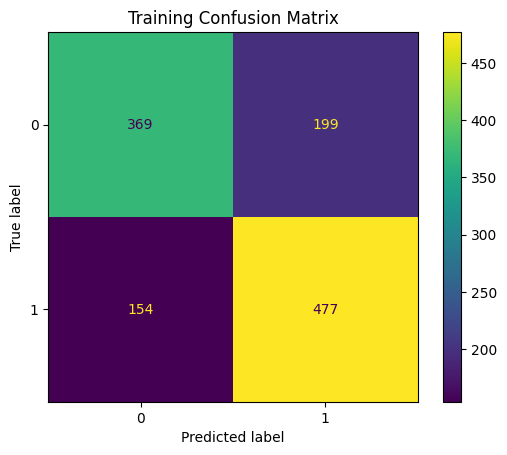

In [14]:
# Evaluate it on training data
acc = accuracy_score(y_train, clf.predict(X_train))
print("On training data, the algorithm reaches {:.2f}% of accuracy".format(acc * 100))

cm = confusion_matrix(y_train, clf.predict(X_train), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title("Training Confusion Matrix")
plt.show()

### 5.2 On testing data

We only considered the algorithm's performances on training data. We must check that it behaves similarly on unseen (testing) data. 

Always check the performance on the testing dataset, as your model will face new data and not the one provided during the training phase.

On testing data, the algorithm reaches an accuracy of 69.33%


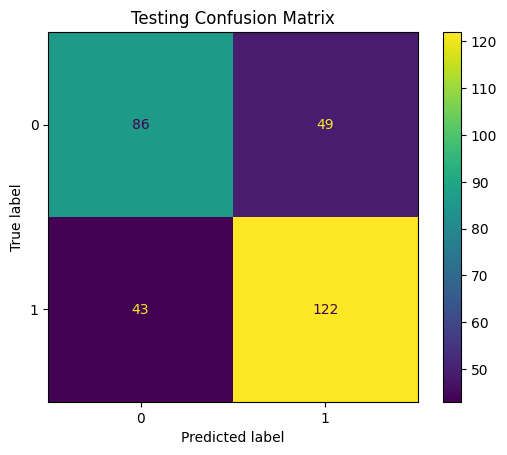

In [15]:
# Evaluate it on testing data
acc = accuracy_score(y_test, clf.predict(X_test))
print("On testing data, the algorithm reaches an accuracy of {:.2f}%".format(acc * 100))

cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title("Testing Confusion Matrix")
plt.show()

-----------------

To simplify the exercises, some functions are defined.

In [16]:
def evaluate_clf(clf, X_train, y_train, X_test, y_test):
    # Evaluate a classifier both on training and testing data

    # First evaluate on train
    acc = accuracy_score(y_train, clf.predict(X_train))
    print(
        "On training data, the algorithm reaches an accuracy of {:.2f}%".format(
            acc * 100
        )
    )
    # Then on test
    acc = accuracy_score(y_test, clf.predict(X_test))
    print(
        "On testing data, the algorithm reaches an accuracy of {:.2f}%".format(
            acc * 100
        )
    )
    # And print the confusion matrix
    cm = confusion_matrix(y_test, clf.predict(X_test), labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.title("Testing Confusion Matrix")
    plt.show()

In [17]:
def create_df_without_irrelevant_features(df, features_to_remove):
    # Create new testing and training dataset without some features

    # Make a copy of the original df, only modify the df_tmp
    df_tmp = df.copy()

    # Remove the features
    df_tmp = df_tmp.drop(columns=features_to_remove)

    # Separate train and test
    df_train, df_test = train_test_split(df_tmp, test_size=0.2, random_state=42)

    # separate target and features
    y_train = df_train["quality"]
    X_train = df_train.drop(columns=["quality"])
    y_test = df_test["quality"]
    X_test = df_test.drop(columns=["quality"])

    return y_train, X_train, y_test, X_test

-----------------

# B. Exercises

The MarkDown/text cells to fill are indicated by <span style="color:red">WRITE HERE</span>.

The code cells to complete/modify are indicated by `""" MODIFY HERE """`.

## 1. Model Tuning

The model presented in the tutorial reached a bad performance. Try to play with the model's hyperparameters to improve its performance (think about the theory behind each hyperparameter). The documentation of the Decision Tree is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [18]:
""" MODIFY HERE """
# Define the model: change the hyperparameters of the model below
clf = DecisionTreeClassifier(
    max_depth=1,  # Integer or None; max depth of the tree
    min_samples_split=2000,  # Integer; min nb of samples to split a node
    min_samples_leaf=5,  # Integer; min nb of samples at a leaf node
    class_weight=None,  # None or "balanced"; weights related to the class
    random_state=42, # fix the seed for reproducibility
)

In [19]:
# Train the model
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2000
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


On training data, the algorithm reaches an accuracy of 52.63%
On testing data, the algorithm reaches an accuracy of 55.00%


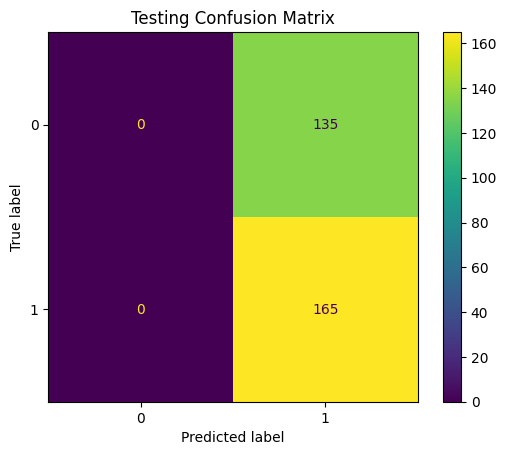

In [20]:
# Check the performance
evaluate_clf(clf, X_train, y_train, X_test, y_test)

The hyperparameters may be automatically searched with a "grid-search". Below, you can choose the range of values to consider during the grid search.

In [21]:
""" MODIFY HERE """
# Change the parameters explored by the grid search below
parameters = {
    "max_depth": (1, 2, None),
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 2, 5],
    "class_weight": (None, "balanced"),
}

In [22]:
# Define the grid search and apply it on training data
clf = GridSearchCV(DecisionTreeClassifier(random_state=42), parameters)
clf.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'class_weight': (None, ...), 'max_depth': (1, ...), 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 3, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [23]:
print(
    "The model that reached the higher performance is defined by: {}".format(
        clf.best_params_
    )
)

The model that reached the higher performance is defined by: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


On training data, the algorithm reaches an accuracy of 100.00%
On testing data, the algorithm reaches an accuracy of 77.67%


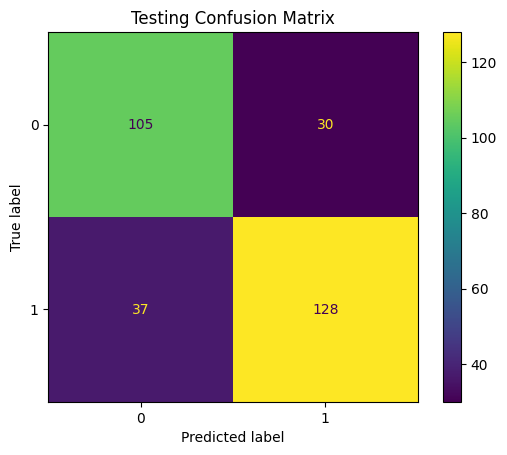

In [24]:
# Check the performance
evaluate_clf(clf, X_train, y_train, X_test, y_test)

## 2. Feature selection

As discussed above (A.3.1 & A.3.2), some features may not add valuable information. From the plots of section A.3, remove some features and see how it influences the model's performance.

In [25]:
""" MODIFY HERE """
# Select the features to remove from the dataframe (column name)
# Insert between the [] the name of these features, for example ["residual sugar", "pH"]
features_to_remove = []

In [26]:
# Define the same model as before to compare the results
clf = DecisionTreeClassifier(
    max_depth=1,  # Integer or None; max depth of the tree
    min_samples_split=10,  # Integer; min nb of samples to split a node
    min_samples_leaf=5,  # Integer; min nb of samples at a leaf node
    class_weight=None,  # None or "balanced"; weights related to the class
    random_state=42, # fix the seed for reproducibility
)

In [27]:
# Remove the selected columns from the dataframe
(
    y_train_tmp,
    X_train_tmp,
    y_test_tmp,
    X_test_tmp,
) = create_df_without_irrelevant_features(df, features_to_remove)

In [28]:
# Train the model
clf.fit(X_train_tmp, y_train_tmp)

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,10
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


On training data, the algorithm reaches an accuracy of 70.56%
On testing data, the algorithm reaches an accuracy of 69.33%


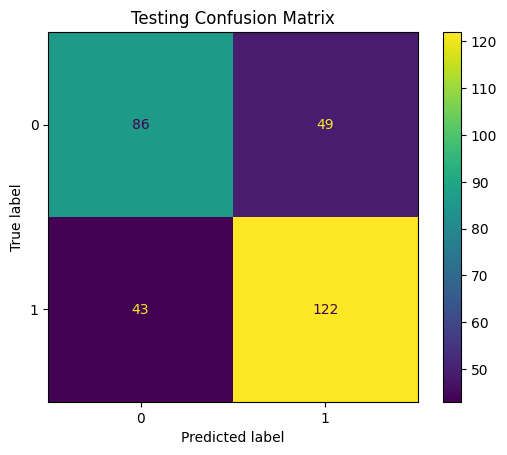

In [29]:
# Check the performance
evaluate_clf(clf, X_train_tmp, y_train_tmp, X_test_tmp, y_test_tmp)

In the cell below, discuss the impact of removing features.

<span style="color:red">WRITE HERE</span>

## 3. Models comparison

Now, you may try others algorithms to see how they perform on this task.

We propose to try three different algorithms: Logistic regression, Random Forest and Multi-Layer Perceptron, the code documentation for each one of them is available in the following links:
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier)
- [Multi-Layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [30]:
""" MODIFY HERE """;
# Select the classifier to use and its hyperparameters
# And comment the two others (using # (for a line) or """ """ (for a group))

clf = LogisticRegression(
    tol=1e-4,  # Float, stopping criteria value
    C=1.0,  # Float, Inverse of the regualrisation factor
    class_weight=None,  # None or "balanced"; weights related to the class
    max_iter=1000,  # Integer, max nb of iteration of the algorithm
    random_state=42, # fix the seed for reproducibility
)

"""
# Define the model, ! change the parameters HERE !
clf = RandomForestClassifier(
    n_estimators=1,  # Integer, nb of trees in the forest
    max_depth=1,  # Integer or None; max depth of the trees
    min_samples_split=10,  # Integer; min nb of samples to split a node
    min_samples_leaf=10,  # Integer; min nb of samples to be at a leaf node
    class_weight=None,  # None or "balanced"; weights related to the class
    random_state=42, # fix the seed for reproducibility
)
""";

"""
# Define the model, ! change the parameters HERE !
clf = MLPClassifier(
    hidden_layer_sizes=(100,100),  # Tuple of integers, each value is the nb of neurons in its layer
                                   # i.e. (200, 200) is a NN with two layers with 200 neurons each
    activation="relu",  # String, activation function ("relu", "tanh",...)
    alpha=0.0001,  # Float, strength of the regularisation
    learning_rate="constant",  # String, how to modifiy the learning rate along time ("constant", "invscaling", ...)
    learning_rate_init=0.1,  # Float, initial learning rate for SGD
    max_iter=100,  # Integer, maximum number of iteration to compute
    random_state=42, # fix the seed for reproducibility
)
""";

In [31]:
# Train the model
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


On training data, the algorithm reaches an accuracy of 74.56%
On testing data, the algorithm reaches an accuracy of 72.67%


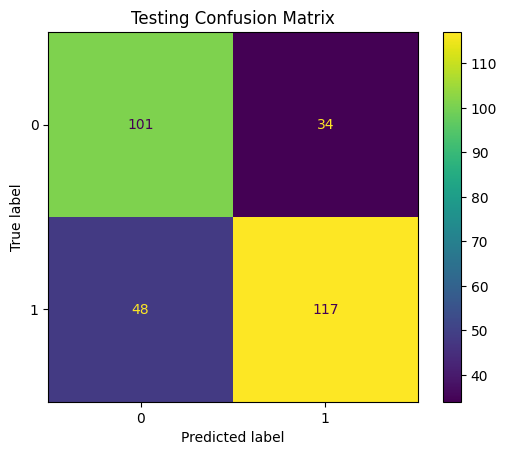

In [32]:
# Check the performance
evaluate_clf(clf, X_train, y_train, X_test, y_test)

In the cell below, record and compare the four different models introduced in this notebook (performance, difficulty to tune, ...).

<span style="color:red">WRITE HERE</span>

## 4. Interpretability

An interesting step is to then understand *how* our best model does the prediction. To so, different interpretability methods can be used. They depend on the algorithm. Here, we will only consider interpretability analysis of a decision tree, because it is the easiest to interpret: we just have to plot it and analyse the branches' criterion.

Below, define the best Decision Tree that you found before and look how it make its decisions.

In [33]:
""" MODIFY HERE """
# Define the model: change the hyperparameters of the model below
clf = DecisionTreeClassifier(
    max_depth=3,  # Integer or None; max depth of the tree
    min_samples_split=100,  # Integer; min nb of samples to split a node
    min_samples_leaf=5,  # Integer; min nb of samples at a leaf node
    class_weight=None,  # None or "balanced"; weights related to the class
    random_state=42, # fix the seed for reproducibility
)

In [34]:
# Train the model
clf.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,100
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


On training data, the algorithm reaches an accuracy of 75.48%
On testing data, the algorithm reaches an accuracy of 71.00%


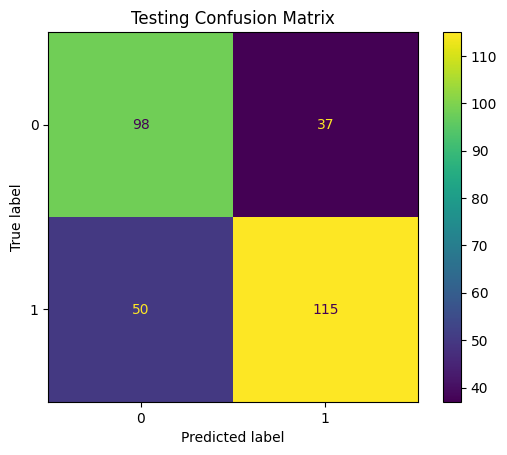

In [35]:
# Check the performance
evaluate_clf(clf, X_train, y_train, X_test, y_test)

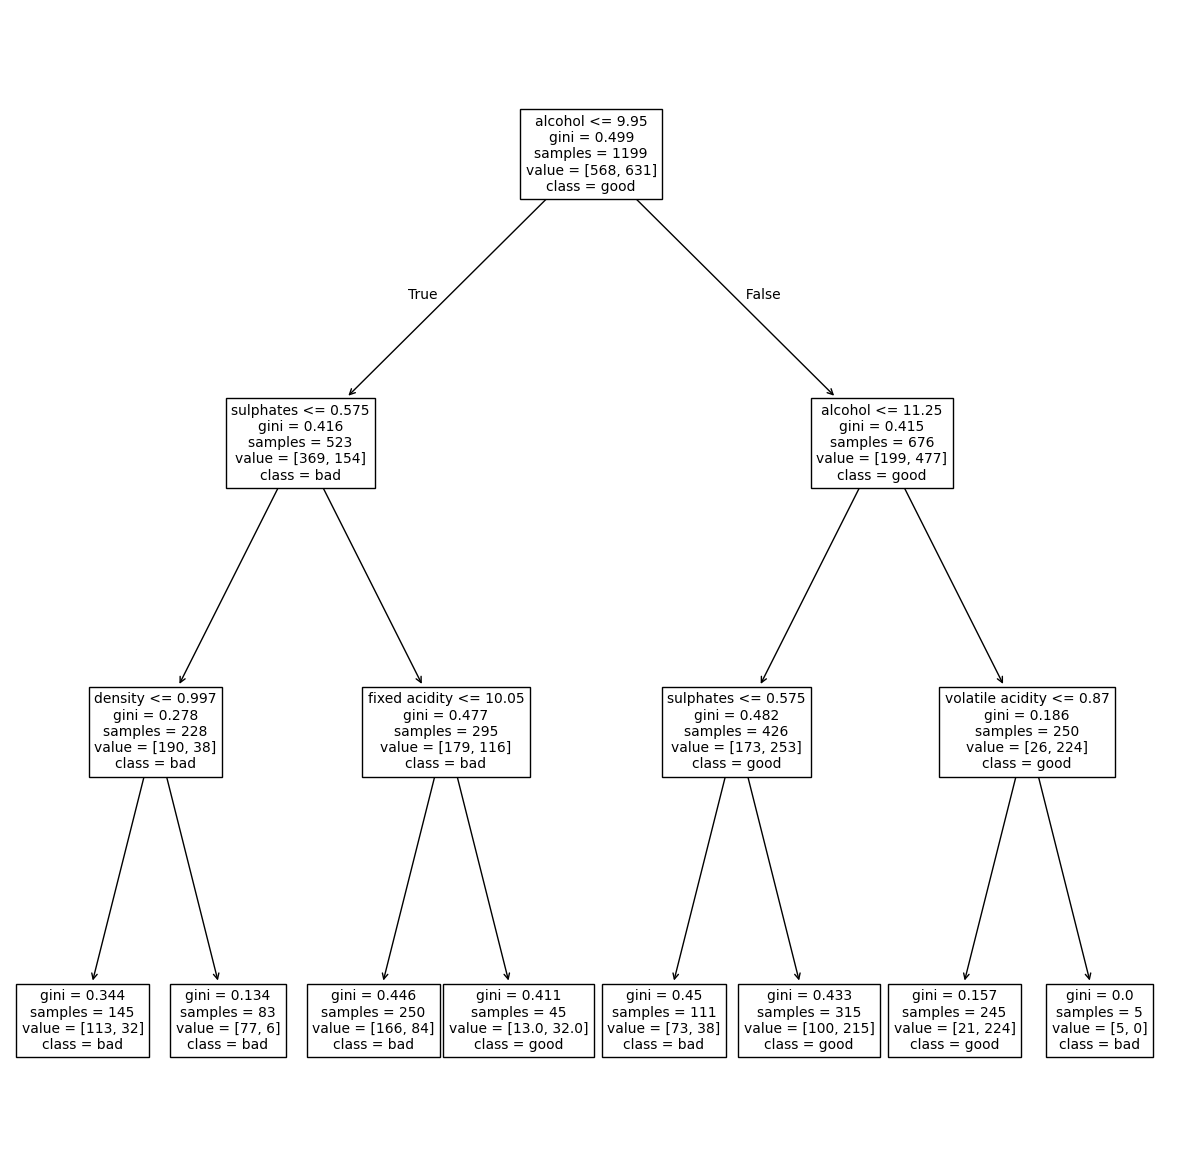

In [36]:
""" MODIFY HERE """
# you can change the size of the figure and the fontsize so the tree is easier to read
plt.figure(figsize=(15,15))
plot_tree(clf, fontsize=10, feature_names=X_train.columns, class_names=["bad", "good"])
plt.show()

Look the plot above and understand what are the classification steps done by the tree. If the plot is very big, you can force it to be smaller by using a smaller `max_depth` when training the tree.

<span style="color:red">WRITE HERE</span>

-----------------

<a name="refs"></a>
References:
- [Dataset source](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [link](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science
- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

---------------